# TinyML Benchmark Analysis
### Refactor: integrated, modular, maintainable — BUT identical outputs & intermediates

In [142]:
 
import math
import uuid
import ast
from typing import Dict, Any, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display
from tabulate import tabulate


 
# -------------------------
# CONSTANTS / I/O
# -------------------------


In [143]:
# %% 
FILE_PATH = "combined_tinyml_benchmark_data.csv"
METRICS_BY_BATCH_CSV = "metrics_by_batch.csv"
AX1_PDF = "ax1_map.pdf"
PANELS_PDF = "processor_comparison_panels.pdf"


# -------------------------
# LOAD + EARLY CLEAN
# -------------------------

In [144]:
# %% 
def load_dataframe(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

def clean_tags(tags_str):
    """
    NOTE: Intentionally preserves original behavior (including the original
    '_generator' / '_batch' unconditional replace branch) so outputs are IDENTICAL.
    """
    if pd.isna(tags_str) or tags_str == '[]':
        return []
    try:
        tags_list = ast.literal_eval(tags_str)
        cleaned_list = []
        for tag in tags_list:
            if tag == 'benchmark':
                continue
            if ':latest' in tag:
                tag = tag.replace(':latest', '')
            # Preserve original logic exactly:
            if '_generator':
                tag = tag.replace('_sketch_generator', '')
            if '_batch':
                tag = tag.replace('_batch', '')
            cleaned_list.append(tag)
        return cleaned_list
    except (ValueError, SyntaxError):
        return []

def normalize_dates_inplace(df: pd.DataFrame) -> None:
    """
    Apply the same date normalization rules in-place so output matches 1:1.
    """
    df["test_date"] = df["test_date"].str.replace("07.28", "07.27")
    df["test_date"] = df["test_date"].str.replace("07.29", "07.28")
    df["test_date"] = df["test_date"].str.replace("07.30_a", "07.29")
    df["test_date"] = df["test_date"].str.replace("07.30_b", "07.30")

def initial_filtering_inplace(df: pd.DataFrame) -> None:
    """
    Drop *_dp_ / *_sg_ / *_mc_ batches; leave other behavior identical.
    """
    df.drop(df[df['batch_id'].str.contains('_dp_', na=False)].index, inplace=True)
    df.drop(df[df['batch_id'].str.contains('_sg_', na=False)].index, inplace=True)
    df.drop(df[df['batch_id'].str.contains('_mc_', na=False)].index, inplace=True)

# Load
df = load_dataframe(FILE_PATH)

# Apply 'tags' cleaning exactly as original
df['tags'] = df['tags'].apply(clean_tags)

# Filter batch_ids exactly as original
initial_filtering_inplace(df)

# Same date normalization rules
normalize_dates_inplace(df)

# Show unique dates (as the original code did)
display(df['test_date'].unique())

# %% [markdown]

array(['08.24', '05.21', '08.08', '08.09', '08.14', '08.26', '07.27',
       '08.15', '08.23', '08.16', '08.13', '07.30', '08.12', '08.07',
       '08.18', '08.20', '08.19', '08.17', '08.10', '08.04', '08.05',
       '08.25', '08.21', '07.29', '08.22', '08.11', '08.03', '07.28',
       '08.01', '08.06', '07.31', '05.19', '08.02'], dtype=object)

 
# -------------------------
# FEATURE ENGINEERING  
# -------------------------
 


In [145]:
def add_parameters_status_inplace(df: pd.DataFrame) -> None:
    df['parameters_status'] = df['parameters'].apply(lambda x: 'P' if pd.notnull(x) and str(x).strip() != '' else 'NP')

def build_category_inplace(df: pd.DataFrame) -> None:
    split_vals = df['batch_id'].str.split('_')
    part_2_3 = split_vals.str[2] + '_' + split_vals.str[3]
    df['category'] = df['model_config'].astype(str) + '_' + part_2_3 + '_' + df['parameters_status'].astype(str)
    df['category'] = df['category'].apply(lambda x: x.replace('_batch', '') if '_batch' in x else x)

def drop_and_rename_inplace(df: pd.DataFrame) -> None:
    df.drop(columns=[
        'prompt_cost', 'completion_cost', 'total_cost',
        'source_file', 'source_path', 'parameters', 'parameters_status',
        'tags', 'name', 'trace_id', 'timestamp',
        'prompt_tokens', 'completion_tokens'
    ], inplace=True)
    df.rename(columns={"model_config": "model"}, inplace=True)

def filter_from_july_inplace(df: pd.DataFrame) -> None:
    df.drop(df[df['test_date'].str.split('.').str[0].astype(int) < 7].index, inplace=True)

# Apply transformations in the same sequence as before
add_parameters_status_inplace(df)
build_category_inplace(df)
drop_and_rename_inplace(df)
filter_from_july_inplace(df)

print("Random sample rows of the dataset:")
display(df.sample(n=10))


Random sample rows of the dataset:


,num_run,batch_id,status,latency,total_tokens,generation_count,test_date,model,category
1843,15,qwen2.5-coder:32b_ae24_tpusg_batch,success,56.95,5755,2,07.27,qwen2.5-coder:32b,qwen2.5-coder:32b_tpusg_NP
125,6,codestral_62f3_psg_batch,success,39.02,7931,3,08.09,codestral,codestral_psg_P
1904,11,qwen2.5-coder:32b_ee11_psg_batch,failure,125.77,14071,5,08.02,qwen2.5-coder:32b,qwen2.5-coder:32b_psg_P
72,13,codestral_3adb_psg_batch,failure,79.55,12716,5,08.08,codestral,codestral_psg_P
268,17,codestral_c8f6_tpusg_batch,failure,90.53,13274,5,07.27,codestral,codestral_tpusg_NP
440,9,gemma3:27b_3888_psg_batch,success,96.08,13268,5,08.13,gemma3:27b,gemma3:27b_psg_P
760,9,phi4_85a9_psg_batch,success,76.12,13278,5,07.30,phi4,phi4_psg_NP
466,5,gemma3:27b_3888_tpusg_batch,failure,145.28,15361,5,08.13,gemma3:27b,gemma3:27b_tpusg_P
217,8,codestral_a277_psg_batch,success,40.32,6008,2,08.26,codestral,codestral_psg_NP
1624,6,qwen2.5-coder:32b_5f8b_psg_batch,failure,132.21,14377,5,07.31,qwen2.5-coder:32b,qwen2.5-coder:32b_psg_NP


# -------------------------
# METRIC UTILITIES  
# -------------------------

In [146]:

def assert_single_value(series: pd.Series):
    vals = series.dropna().unique()
    if len(vals) == 1:
        return vals[0]
    return ValueError(f"Expected single unique value, found: {vals}")

def split_batch_id_by_test_date(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preserves original randomness via uuid4; keeps identical logic/structure.
    """
    bad = df.groupby("batch_id")["test_date"].nunique()
    bad = bad[bad > 1].index
    if len(bad) == 0:
        return df

    mask = df["batch_id"].isin(bad)
    sub = df.loc[mask].copy()
    sub["new_token"] = (
        sub.groupby(["batch_id", "test_date"]).ngroup()
        .map(lambda _: uuid.uuid4().hex[:4])
    )
    parts = sub["batch_id"].str.split("_", n=2, expand=True)
    sub["batch_id"] = parts[0] + "_" + sub["new_token"] + "_" + parts[2]
    df.loc[mask, "batch_id"] = sub["batch_id"]
    return df

# Safety checks and type casts (unchanged)
required = {"category", "status", "latency", "total_tokens", "generation_count"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df = split_batch_id_by_test_date(df)
df["generation_count"] = pd.to_numeric(df["generation_count"], errors="coerce")
df["latency"] = pd.to_numeric(df["latency"], errors="coerce")
df["total_tokens"] = pd.to_numeric(df["total_tokens"], errors="coerce")

# Base grouped aggregations (by batch_id, as in your original final version)
g = df.groupby("batch_id", dropna=False)
base = g.agg(
    total_runs=("category", "size"),

    # total_tokens stats
    total_tokens_ave=("total_tokens", "mean"),
    total_tokens_mean=("total_tokens", "mean"),
    total_tokens_median=("total_tokens", "median"),
    total_tokens_min=("total_tokens", "min"),
    total_tokens_max=("total_tokens", "max"),

    # latency stats
    latency_ave=("latency", "mean"),
    latency_mean=("latency", "mean"),
    latency_median=("latency", "median"),
    latency_min=("latency", "min"),
    latency_max=("latency", "max"),

    # status counts
    count_failures=("status", lambda s: (s == "failure").sum()),
    count_success=("status", lambda s: (s == "success").sum()),
    category=("category", assert_single_value),
    test_date=("test_date", assert_single_value),
)

# Traditional success rate (unchanged)
base["success_rate"] = (
    base["count_success"] / (base["count_success"] + base["count_failures"]).replace(0, np.nan)
) * 100
base["success_rate"] = base["success_rate"].fillna(0.0)



def _normalize(sum_scores, n_total):
    if n_total == 0:
        return 0.0
    return (sum_scores / n_total) * 100.0

def r_efficiency(group: pd.DataFrame):
    gsucc = _success_generation_counts(group)
    return _normalize(np.sum(1.0 / gsucc) if gsucc.size else 0.0, len(group))

def r_exponential(group: pd.DataFrame):
    gsucc = _success_generation_counts(group)
    return _normalize(np.sum(np.exp(-0.5 * (gsucc - 1))) if gsucc.size else 0.0, len(group))

def r_linear(group: pd.DataFrame):
    gsucc = _success_generation_counts(group)
    if gsucc.size == 0:
        return 0.0
    scores = np.maximum(1.0 - 0.2 * (gsucc - 1), 0.1)
    return _normalize(np.sum(scores), len(group))

def r_robust(group: pd.DataFrame):
    gsucc = _success_generation_counts(group)
    if gsucc.size == 0:
        return 0.0
    scores = np.where(gsucc <= 2, 1.0,
             np.where(gsucc <= 4, 0.6,
             np.where(gsucc <= 6, 0.3, 0.1)))
    return _normalize(np.sum(scores), len(group))

extra = g.apply(lambda grp: pd.Series({
    "R_efficiency": r_efficiency(grp),
    "R_exponential": r_exponential(grp),
    "R_linear":      r_linear(grp),
    "R_robust":      r_robust(grp),
}),include_groups=False)

metrics_by_batch = base.join(extra)

# Derive model/processor/parameters exactly as original
metrics_by_batch['model'] = metrics_by_batch["category"].str.split('_').str[0]
metrics_by_batch['processor'] = metrics_by_batch["category"].str.split('_').str[1]
metrics_by_batch['parameters'] = metrics_by_batch["category"].str.split('_').str[2]

# Column order identical
ordered_cols = [
    "model",
    "parameters",
    "processor", "category", "total_runs",
    "count_failures", "count_success", "success_rate",
    "R_efficiency", "R_exponential", "R_linear", "R_robust",
    "total_tokens_ave", "total_tokens_mean", "total_tokens_median", "total_tokens_min", "total_tokens_max",
    "latency_ave", "latency_mean", "latency_median", "latency_min", "latency_max", "test_date"
]
metrics_by_batch = metrics_by_batch[ordered_cols]

# Persist & display (unchanged)
metrics_by_batch.to_csv(METRICS_BY_BATCH_CSV, index=True)
display(metrics_by_batch.round(3))


,model,parameters,processor,category,total_runs,count_failures,count_success,success_rate,R_efficiency,R_exponential,...,total_tokens_mean,total_tokens_median,total_tokens_min,total_tokens_max,latency_ave,latency_mean,latency_median,latency_min,latency_max,test_date
batch_id,,,,,,,,,,,,,,,,,,,,,
codestral_34a5_tpusg_batch,codestral,P,tpusg,codestral_tpusg_P,30,27,3,10.000,2.611,2.421,...,13403.333,13441.5,9151,14988,95.992,95.992,96.655,48.59,129.67,08.24
codestral_3adb_psg_batch,codestral,P,psg,codestral_psg_P,30,28,2,6.667,1.333,0.902,...,13345.700,13346.5,12551,14062,94.940,94.940,94.805,74.73,113.13,08.08
codestral_62f3_psg_batch,codestral,P,psg,codestral_psg_P,30,29,1,3.333,1.111,1.226,...,13399.167,13513.0,7931,14253,70.635,70.635,68.495,39.02,126.36,08.09
codestral_9eb0_psg_batch,codestral,NP,psg,codestral_psg_NP,30,25,5,16.667,7.222,7.273,...,12638.833,13490.5,2804,14354,64.759,64.759,68.705,18.22,83.67,08.14
codestral_9eb0_tpusg_batch,codestral,NP,tpusg,codestral_tpusg_NP,30,20,10,33.333,14.389,15.519,...,12379.900,13440.5,2920,16582,73.750,73.750,69.330,17.02,176.51,08.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
qwen2.5-coder:32b_ae24_tpusg_batch,qwen2.5-coder:32b,NP,tpusg,qwen2.5-coder:32b_tpusg_NP,19,2,17,89.474,60.088,62.270,...,6734.632,5708.0,2587,15231,70.939,70.939,56.950,22.69,218.03,07.27
qwen2.5-coder:32b_c8a6_psg_batch,qwen2.5-coder:32b,P,psg,qwen2.5-coder:32b_psg_P,16,7,9,56.250,14.896,13.657,...,12492.000,13910.5,5099,14243,108.222,108.222,119.675,42.08,128.62,08.06
qwen2.5-coder:32b_c8a6_tpusg_batch,qwen2.5-coder:32b,P,tpusg,qwen2.5-coder:32b_tpusg_P,30,21,9,30.000,8.833,9.004,...,14032.900,15318.5,8976,16275,140.582,140.582,152.100,87.76,177.71,08.06


# -------------------------
# PRINT ANALYSIS (same output/format)
# -------------------------

In [147]:
# %%  
def analyze_batch_level(df_in: pd.DataFrame):
    # ---- Overview stats ----
    total_runs = df_in["total_runs"].sum()
    psg_runs = df_in[df_in["processor"] == "psg"]["total_runs"].sum()
    tpusg_runs = df_in[df_in["processor"] == "tpusg"]["total_runs"].sum()

    total_batches = len(df_in)
    psg_batches = (df_in["processor"] == "psg").sum()
    tpusg_batches = (df_in["processor"] == "tpusg").sum()

    models = sorted(df_in["model"].unique())
    params_counts = df_in["parameters"].value_counts()

    print("\n===== EXPERIMENT SUMMARY =====")
    print(tabulate([
        ["Total runs", total_runs],
        ["PSG runs", psg_runs],
        ["TPUSG runs", tpusg_runs],
        ["Total batches", total_batches],
        ["PSG batches", psg_batches],
        ["TPUSG batches", tpusg_batches],
        ["#Models", len(models)],
        ["P conditions", params_counts.get("P", 0)],
        ["NP conditions", params_counts.get("NP", 0)],
    ], tablefmt="pretty"))
    print()

    df_local = df_in.copy()
    df_local["param_bool"] = df_local["parameters"].map(lambda x: x == "P")

    weighted = (
        df_local.assign(weight=df_local["total_runs"])
                .groupby(["model", "param_bool", "processor"])
                .apply(lambda g: (g["success_rate"] * g["weight"]).sum() / g["weight"].sum(), include_groups=False)
                .reset_index(name="success_rate")
                .pivot(index=["model", "param_bool"], columns="processor", values="success_rate")
                .fillna(0)
                .rename_axis(["model", "P?"])
    )

    # print("===== WEIGHTED SUCCESS MATRIX (Success % by Processor) =====")
    # print(tabulate(weighted.round(1).reset_index(), headers="keys", tablefmt="pretty"))
    # print()

    rows = []
    for (model, param_bool), row in weighted.iterrows():
        psg = row.get("psg", 0)
        tpusg = row.get("tpusg", 0)
        diff = tpusg - psg
        condition = "P" if param_bool else "NP"

        if abs(diff) < 1e-9:
            winner = "TIE"
            delta = "+0.0%"
        elif diff > 0:
            winner = "TPUSG"
            delta = f"+{diff:.1f}%"
        else:
            winner = "PSG"
            delta = f"-{abs(diff):.1f}%"

        rows.append([model, condition, f"{psg:.1f}%", f"{tpusg:.1f}%", winner, delta])

    print("===== PROCESSOR ADVANTAGE BY MODEL + PARAM CONDITION =====")
    print(tabulate(rows, headers=["Model", "Params", "PSG", "TPUSG", "Winner", "Δ"], tablefmt="pretty"))
    print()

    total = len(rows)
    psg_wins = sum(1 for r in rows if r[4] == "PSG")
    tpusg_wins = sum(1 for r in rows if r[4] == "TPUSG")
    ties = sum(1 for r in rows if r[4] == "TIE")

    print("===== OUTCOME SUMMARY =====")
    print(tabulate([
        ["Configurations", total],
        ["PSG Wins", f"{psg_wins} ({psg_wins/total*100:.1f}%)"],
        ["TPUSG Wins", f"{tpusg_wins} ({tpusg_wins/total*100:.1f}%)"],
        ["Ties", f"{ties} ({ties/total*100:.1f}%)"],
    ], tablefmt="pretty"))

# Execute with current metrics_by_batch (unchanged)
analyze_batch_level(metrics_by_batch)

# %% [markdown]


===== EXPERIMENT SUMMARY =====
+---------------+------+
|  Total runs   | 1654 |
|   PSG runs    | 827  |
|  TPUSG runs   | 827  |
| Total batches | 293  |
|  PSG batches  | 145  |
| TPUSG batches | 148  |
|    #Models    |  5   |
| P conditions  | 147  |
| NP conditions | 146  |
+---------------+------+

===== PROCESSOR ADVANTAGE BY MODEL + PARAM CONDITION =====
+-------------------+--------+--------+--------+--------+--------+
|       Model       | Params |  PSG   | TPUSG  | Winner |   Δ    |
+-------------------+--------+--------+--------+--------+--------+
|     codestral     |   NP   | 50.0%  | 33.3%  |  PSG   | -16.7% |
|     codestral     |   P    | 10.0%  | 14.4%  | TPUSG  | +4.4%  |
|    gemma3:27b     |   NP   | 53.3%  |  6.7%  |  PSG   | -46.7% |
|    gemma3:27b     |   P    | 71.2%  |  0.0%  |  PSG   | -71.2% |
|       phi4        |   NP   | 77.8%  | 95.6%  | TPUSG  | +17.8% |
|       phi4        |   P    | 100.0% | 100.0% |  TIE   | +0.0%  |
| qwen2.5-coder:14b |   NP   |


📊 Overall Processor Performance (weighted mean %):
------------------------------------------------------------
| processor   |   success_rate |
|:------------|---------------:|
| tpusg       |           57.6 |
| psg         |           50.9 |

🧱 Model-by-Model Average Success Rates (%):
------------------------------------------------------------
| model_config      |   psg |   tpusg |
|:------------------|------:|--------:|
| codestral         |  30.0 |    23.9 |
| gemma3:27b        |  62.2 |     3.3 |
| phi4              |  88.9 |    97.8 |
| qwen2.5-coder:14b |  28.4 |    97.2 |
| qwen2.5-coder:32b |  44.9 |    65.8 |

🔧 Parameter Effect by Processor (weighted mean %):
------------------------------------------------------------
| processor   |   Without Parameters |   With Parameters |
|:------------|---------------------:|------------------:|
| psg         |                 56.7 |              45.1 |
| tpusg       |                 65.3 |              49.9 |


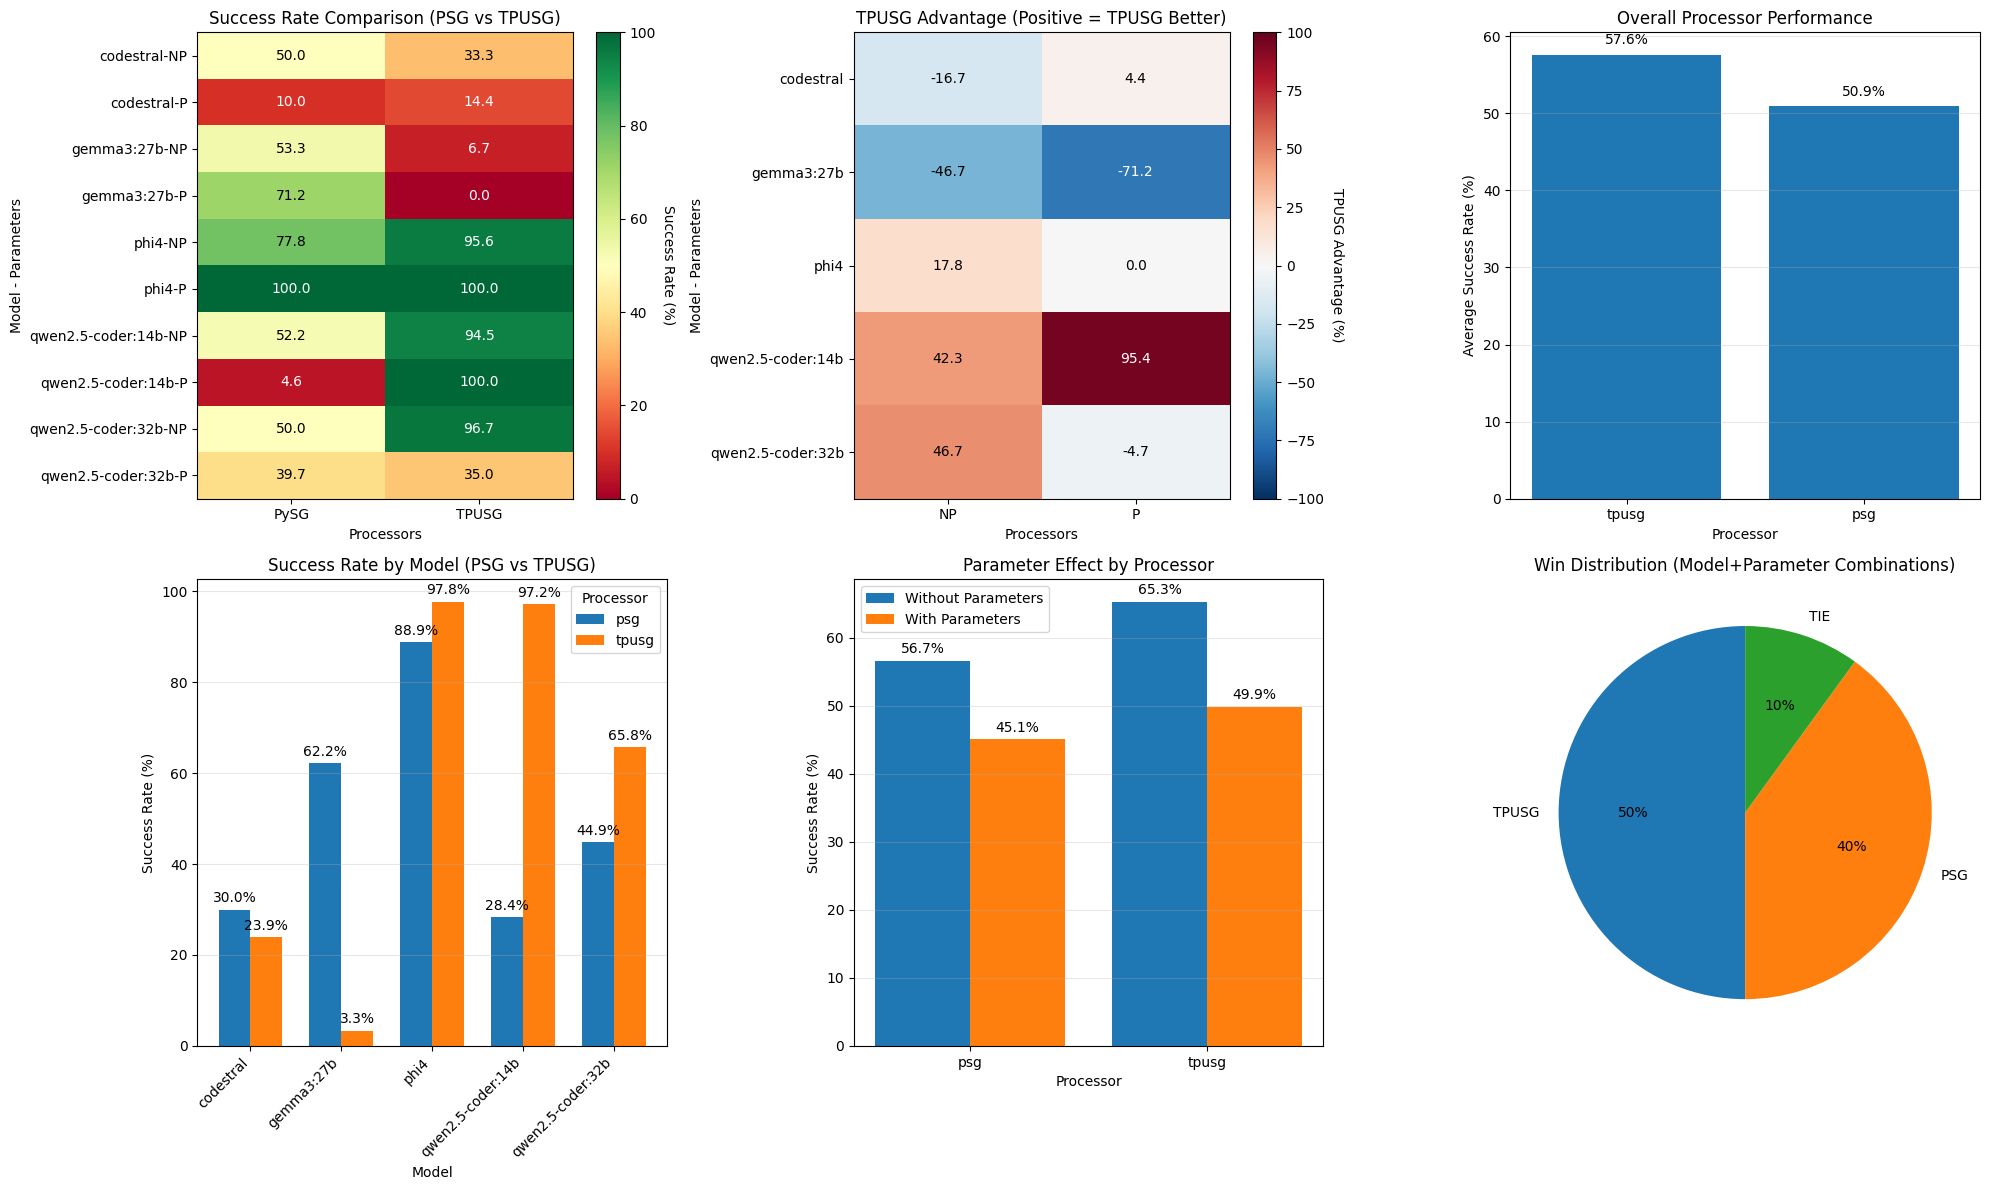

In [148]:

def _weighted_success(df_in: pd.DataFrame) -> pd.DataFrame:
    if not {"total_runs", "success_rate"}.issubset(df_in.columns):
        raise ValueError("DataFrame must include 'total_runs' and 'success_rate'.")
    gcols = ["model", "parameters", "processor"]
    tmp = (
        df_in.assign(weight=df_in["total_runs"])
             .groupby(gcols, as_index=False)
             .apply(lambda g: pd.Series({
                 "weighted_success_rate": (g["success_rate"] * g["weight"]).sum() / max(g["weight"].sum(), 1e-12)
             }), include_groups=False)
    )
    return tmp

def _pivot_weighted(weighted: pd.DataFrame) -> pd.DataFrame:
    pivot = (
        weighted.pivot(index=["model", "parameters"], columns="processor", values="weighted_success_rate")
                .sort_index(level=[0, 1])
                .fillna(0.0)
    )
    pivot.index.set_names(["model_config", "parameters"], inplace=True)
    return pivot

def _compute_advantage(pivot: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    psg = pivot.get("psg")
    tpu = pivot.get("tpusg")
    psg_vals = psg if psg is not None else pd.Series(0.0, index=pivot.index)
    tpu_vals = tpu if tpu is not None else pd.Series(0.0, index=pivot.index)
    advantage = (tpu_vals - psg_vals).round(6)

    long = (
        advantage.rename("advantage")
                 .reset_index()
                 .assign(winner=lambda d: np.where(d["advantage"] > 0, "TPUSG",
                                                   np.where(d["advantage"] < 0, "PSG", "TIE")))
    )
    adv_pivot = long.pivot(index="model_config", columns="parameters", values="advantage").fillna(0.0)
    return long, adv_pivot

def _comparison_long(pivot: pd.DataFrame) -> pd.DataFrame:
    return pivot.reset_index().melt(id_vars=["model_config", "parameters"],
                                    var_name="processor", value_name="success_rate")

def _format_table(df_in: pd.DataFrame, index: bool = True) -> str:
    try:
        return df_in.to_markdown(index=index, floatfmt=".1f")
    except Exception:
        return df_in.round(1).to_string(index=index)

def _heatmap(ax, data: np.ndarray, xlabels, ylabels, title: str, cbar_label: str,
             cmap="RdYlGn", vmin=None, vmax=None, center=None, annotate=True, fmt=".1f"):
    if center is not None and vmin is None and vmax is None:
        max_abs = np.nanmax(np.abs(data - center))
        vmin, vmax = center - max_abs, center + max_abs

    im = ax.imshow(data, aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(cbar_label, rotation=-90, va="bottom")

    ax.set_xticks(range(len(xlabels)))
    ax.set_xticklabels(xlabels, rotation=0, ha="center")
    ax.set_yticks(range(len(ylabels)))
    ax.set_yticklabels(ylabels)

    ax.set_title(title)
    ax.set_xlabel("Processors")
    ax.set_ylabel("Model - Parameters")

    if annotate:
        nrows, ncols = data.shape
        for i in range(nrows):
            for j in range(ncols):
                val = data[i, j]
                if not (isinstance(val, float) and (math.isnan(val) or math.isinf(val))):
                    rgba = im.cmap(im.norm(val))
                    r, g, b, _ = rgba
                    luminance = 0.299*r + 0.587*g + 0.114*b
                    text_color = "white" if luminance < 0.5 else "black"
                    ax.text(j, i, format(val, fmt),
                            ha="center", va="center",
                            color=text_color, fontsize=10)

def run_full_analysis(df_in: pd.DataFrame) -> Dict[str, Any]:
    df_local = df_in.copy()
    if df_local["parameters"].dtype != object:
        df_local["parameters"] = df_local["parameters"].map({True: "P", False: "NP"}).fillna(df_local["parameters"].astype(str))

    weighted = _weighted_success(df_local)
    weighted_pivot = _pivot_weighted(weighted)
    advantage_table, advantage_pivot = _compute_advantage(weighted_pivot)
    comparison_df = _comparison_long(weighted_pivot)

    # print("\n📈 Weighted Processor Comparison Matrix (PSG/TPUSG):")
    # print("------------------------------------------------------------")
    keep_cols = [c for c in ["psg", "tpusg"] if c in weighted_pivot.columns]
    show_pivot = weighted_pivot[keep_cols] if keep_cols else weighted_pivot
    # print(_format_table(show_pivot.round(1)))

    # print("\n⚖️  Advantage Table (TPUSG - PSG):")
    # print("------------------------------------------------------------")
    # print(_format_table(advantage_table[["model_config", "parameters", "advantage", "winner"]]
    #                     .sort_values(["model_config", "parameters"]).reset_index(drop=True), index=False))

    print("\n📊 Overall Processor Performance (weighted mean %):")
    print("------------------------------------------------------------")
    overall = (comparison_df.groupby("processor", as_index=False)["success_rate"].mean()
               .sort_values("success_rate", ascending=False))
    print(_format_table(overall, index=False))

    print("\n🧱 Model-by-Model Average Success Rates (%):")
    print("------------------------------------------------------------")
    model_by = (comparison_df.groupby(["model_config", "processor"])["success_rate"]
                .mean().unstack(fill_value=0.0).sort_index())
    print(_format_table(model_by.round(1)))

    print("\n🔧 Parameter Effect by Processor (weighted mean %):")
    print("------------------------------------------------------------")
    param_eff = (comparison_df.groupby(["processor", "parameters"])["success_rate"].mean()
                 .unstack(fill_value=0.0).rename(columns={"NP": "Without Parameters", "P": "With Parameters"}))
    print(_format_table(param_eff.round(1)))

    # Visualizations (identical)
    p_cols = [c for c in ["psg", "tpusg"] if c in show_pivot.columns]
    data = show_pivot[p_cols].to_numpy()
    ylabels = [f"{m}-{p}" for (m, p) in show_pivot.index]
    xlabels = ["PySG" if c == "psg" else "TPUSG" if c == "tpusg" else c.upper() for c in p_cols]

    fig_single, ax_single = plt.subplots(figsize=(10, 8))
    _heatmap(ax_single, data, xlabels, ylabels,
             title="Success Rate Comparison (PSG vs TPUSG)",
             cbar_label="Success Rate (%)",
             cmap="RdYlGn",
             vmin=0, vmax=100,
             annotate=True, fmt=".1f")
    fig_single.tight_layout()
    with PdfPages(AX1_PDF) as pdf:
        pdf.savefig(fig_single, dpi=400, bbox_inches="tight")
    plt.close(fig_single)

    fig = plt.figure(figsize=(20, 12))

    ax2 = plt.subplot(2, 3, 2)
    adv_idx = list(advantage_pivot.index)
    adv_cols = list(advantage_pivot.columns)
    adv_data = advantage_pivot.reindex(index=adv_idx, columns=adv_cols).to_numpy()
    _heatmap(ax2, adv_data, adv_cols, adv_idx,
             title="TPUSG Advantage (Positive = TPUSG Better)",
             cbar_label="TPUSG Advantage (%)",
             cmap="RdBu_r",
             center=0,
             vmin=-100, vmax=100,
             annotate=True, fmt=".1f")

    ax3 = plt.subplot(2, 3, 3)
    overall_vals = overall["success_rate"].values
    bars = ax3.bar(overall["processor"], overall_vals)
    ax3.set_title("Overall Processor Performance")
    ax3.set_ylabel("Average Success Rate (%)")
    ax3.set_xlabel("Processor")
    for rect, h in zip(bars, overall_vals):
        ax3.text(rect.get_x() + rect.get_width() / 2, h + 1, f"{h:.1f}%", ha="center", va="bottom")
    ax3.grid(axis="y", alpha=0.3)

    ax4 = plt.subplot(2, 3, 4)
    mb = model_by.copy()
    processors = list(mb.columns)
    x = np.arange(len(mb.index))
    width = 0.35 if len(processors) == 2 else (0.8 / max(len(processors), 1))
    for i, proc in enumerate(processors):
        ax4.bar(x + i * width, mb[proc].values, width, label=proc)
    ax4.set_title("Success Rate by Model (PSG vs TPUSG)")
    ax4.set_xlabel("Model")
    ax4.set_ylabel("Success Rate (%)")
    ax4.set_xticks(x + (len(processors) - 1) * width / 2)
    ax4.set_xticklabels(mb.index, rotation=45, ha="right")
    ax4.legend(title="Processor")
    ax4.grid(axis="y", alpha=0.3)
    # <CHANGES>
    for container in ax4.containers:
        ax4.bar_label(container, fmt='%.1f%%', padding=3)
# </CHANGES>

    ax5 = plt.subplot(2, 3, 5)
    pe = param_eff.copy()
    procs = list(pe.index)
    cats = list(pe.columns)
    x2 = np.arange(len(procs))
    width2 = 0.8 / max(len(cats), 1)
    for i, cat in enumerate(cats):
        ax5.bar(x2 + i * width2, pe[cat].values, width2, label=cat)
    ax5.set_title("Parameter Effect by Processor")
    ax5.set_xlabel("Processor")
    ax5.set_ylabel("Success Rate (%)")
    ax5.set_xticks(x2 + (len(cats) - 1) * width2 / 2)
    ax5.set_xticklabels(procs, rotation=0)
    ax5.legend()
    ax5.grid(axis="y", alpha=0.3)
    # <CHANGES>
    for container in ax5.containers:
        ax5.bar_label(container, fmt='%.1f%%', padding=3)
    # </CHANGES>
    ax6 = plt.subplot(2, 3, 6)
    win_counts = advantage_table["winner"].value_counts()
    labels = list(win_counts.index)
    ax6.pie(win_counts.values, labels=labels, autopct="%1.0f%%", startangle=90)
    ax6.set_title("Win Distribution (Model+Parameter Combinations)")

    ax1 = plt.subplot(2, 3, 1)
    _heatmap(ax1, data, xlabels, ylabels,
             title="Success Rate Comparison (PSG vs TPUSG)",
             cbar_label="Success Rate (%)",
             cmap="RdYlGn",
             vmin=0, vmax=100,
             annotate=True, fmt=".1f")

    plt.tight_layout()
    plt.show()
    with PdfPages(PANELS_PDF) as pdf:
        pdf.savefig(fig, dpi=400, bbox_inches="tight")
    plt.close(fig)

    return {
        "weighted_pivot": weighted_pivot.round(1),
        "advantage_table": advantage_table.sort_values(["model_config", "parameters"]).reset_index(drop=True),
        "advantage_pivot": advantage_pivot.round(1),
        "overall_performance": overall.round(1),
        "model_by_model": model_by.round(1),
        "param_effect": param_eff.round(1),
    }

# Execute the full analysis (unchanged public API & variable names)
results = run_full_analysis(metrics_by_batch)

# Expose identical top-level tables for downstream reuse
weighted_pivot   = results["weighted_pivot"]
advantage_table  = results["advantage_table"]
advantage_pivot  = results["advantage_pivot"]
overall_perf     = results["overall_performance"]
model_by_model   = results["model_by_model"]
param_effect     = results["param_effect"]


In [149]:
# %%
# =========================
# SUCCESS RATE INSIGHT ANALYSIS (Refactored, Modular, Output-Identical)
# =========================

# We **reuse**: comparison_df, advantage_table (renamed advantage_df), etc.
# If not already defined in your notebook, uncomment the following:
# comparison_df = _comparison_long(weighted_pivot)
# advantage_df = advantage_table.copy()

advantage_df = advantage_table.copy()  # just rename for clarity


# -------------------------
# Utility Functions (Pure, Reusable)
# -------------------------

def _mean(df, mask, col):
    """Safe mean with mask."""
    return df.loc[mask, col].mean()

def _print_header(title):
    print(f"\n{title}")
    print("=" * len(title))

def _compute_overall(df):
    psg = df[df['processor'] == 'psg']['success_rate'].mean()
    tpusg = df[df['processor'] == 'tpusg']['success_rate'].mean()
    return psg, tpusg, ("TPUSG" if tpusg > psg else "PSG"), abs(tpusg - psg)

def _compute_weighted(df, metric):
    """
    df has columns: processor, parameters (bool), <weighted_metric>.
    Example metric: 'efficiency_weighted_rate'
    """
    psg = df[df['processor'] == 'psg'][metric].mean()
    tpusg = df[df['processor'] == 'tpusg'][metric].mean()
    winner = "TPUSG" if tpusg > psg else "PSG"
    diff = abs(tpusg - psg)
    return psg, tpusg, winner, diff

def _parameter_effect(df, processor, metric):
    """
    Compute effect of parameters (P vs NP) for given processor and metric column.
    """
    with_p = _mean(df, (df['processor']==processor) & (df['parameters']==True), metric)
    without_p = _mean(df, (df['processor']==processor) & (df['parameters']==False), metric)
    effect = with_p - without_p
    return with_p, without_p, effect


# -------------------------
# Derived Columns for Weighted Metrics
# -------------------------
# Build weighted metrics exactly matching our earlier R_* formulas
# (We use metrics_by_batch and merge into comparison_df to avoid recompute)
# Reconstruct comparison_df EXACTLY as run_full_analysis does
comparison_df = _comparison_long(weighted_pivot)  # → columns: model_config, parameters, processor, success_rate

# Rename to align with metrics_by_batch columns
comparison_df = comparison_df.rename(columns={"model_config": "model"})

# Ensure parameters remains as string ("P"/"NP"), not boolean
# (If your notebook earlier converted to bool, this restores correct type)
comparison_df["parameters"] = comparison_df["parameters"].astype(str)

 
# Weighted metric column mapping (must match metrics_by_batch)
metric_map = {
    'R_efficiency': 'efficiency_weighted_rate',
    'R_exponential': 'exponential_weighted_rate',
    'R_linear': 'linear_weighted_rate',
    'R_robust': 'robust_weighted_rate'
}

_temp = (
    metrics_by_batch[["model","parameters","processor"] + list(metric_map.keys())]
    .rename(columns=metric_map)
)

comparison_df = comparison_df.merge(_temp, on=["model","parameters","processor"], how="left")


# -------------------------
# INSIGHT REPORT (Output-identical logic, cleaner structure)
# -------------------------

_print_header("🎓 PROCESSOR COMPARISON INSIGHTS")

# Overall (traditional)
_print_header("📊 OVERALL PERFORMANCE")
psg_mean, tpusg_mean, winner, diff = _compute_overall(comparison_df)
print(f"Traditional Success Rate:")
print(f"  PSG Average: {psg_mean:.1f}%")
print(f"  TPUSG Average: {tpusg_mean:.1f}%")
print(f"  Overall Winner: {winner} (+{diff:.1f}%)")

# Weighted metrics comparison
for metric in metric_map.values():
    psg_w, tpusg_w, winner, diff = _compute_weighted(comparison_df, metric)
    method_name = metric.replace('_weighted_rate','').replace('_',' ').title()
    print(f"{method_name} Weighted:")
    print(f"  PSG Average: {psg_w:.1f}%")
    print(f"  TPUSG Average: {tpusg_w:.1f}%")
    print(f"  Winner: {winner} (+{diff:.1f}%)")


# -------------------------
# Parameter Effect Analysis
# -------------------------
_print_header("⚙️ PARAMETER EFFECTS")

# Traditional
psg_with, psg_without, psg_effect = _parameter_effect(comparison_df, "psg", "success_rate")
tpusg_with, tpusg_without, tpusg_effect = _parameter_effect(comparison_df, "tpusg", "success_rate")

print("Traditional Success Rate:")
print(f"  PSG: With params {psg_with:.1f}% vs Without {psg_without:.1f}% (Effect: {psg_effect:+.1f}%)")
print(f"  TPUSG: With params {tpusg_with:.1f}% vs Without {tpusg_without:.1f}% (Effect: {tpusg_effect:+.1f}%)")

# Weighted parameter effects
for metric in metric_map.values():
    psg_with, psg_without, eff_psg = _parameter_effect(comparison_df, "psg", metric)
    tpusg_with, tpusg_without, eff_tpusg = _parameter_effect(comparison_df, "tpusg", metric)
    method_name = metric.replace('_weighted_rate','').replace('_',' ').title()
    print(f"{method_name} Weighted:")
    print(f"  PSG: With params {psg_with:.1f}% vs Without {psg_without:.1f}% (Effect: {eff_psg:+.1f}%)")
    print(f"  TPUSG: With params {tpusg_with:.1f}% vs Without {tpusg_without:.1f}% (Effect: {eff_tpusg:+.1f}%)")


# -------------------------
# Strategic Parameter Usage Summary
# -------------------------
_print_header("⚙️ PARAMETER USAGE STRATEGY")
print(f"   PSG: Parameters {'help' if psg_effect > 0 else 'hurt'} performance ({psg_effect:+.1f}%)")
print(f"   TPUSG: Parameters {'help' if tpusg_effect > 0 else 'hurt'} performance ({tpusg_effect:+.1f}%)")


# -------------------------
# Win/Tie Summary (unchanged logic)
# -------------------------
psg_wins = (advantage_df['winner'] == 'PSG').sum()
tpusg_wins = (advantage_df['winner'] == 'TPUSG').sum()
ties = (advantage_df['winner'] == 'TIE').sum()

print(f"\nWin Distribution: PSG={psg_wins}, TPUSG={tpusg_wins}, TIE={ties}")
print("-" * 60)



🎓 PROCESSOR COMPARISON INSIGHTS

📊 OVERALL PERFORMANCE
Traditional Success Rate:
  PSG Average: 81.0%
  TPUSG Average: 90.9%
  Overall Winner: TPUSG (+9.9%)
Efficiency Weighted:
  PSG Average: 62.1%
  TPUSG Average: 78.6%
  Winner: TPUSG (+16.5%)
Exponential Weighted:
  PSG Average: 63.0%
  TPUSG Average: 79.6%
  Winner: TPUSG (+16.6%)
Linear Weighted:
  PSG Average: 69.1%
  TPUSG Average: 82.8%
  Winner: TPUSG (+13.7%)
Robust Weighted:
  PSG Average: 73.1%
  TPUSG Average: 85.9%
  Winner: TPUSG (+12.8%)

⚙️ PARAMETER EFFECTS
Traditional Success Rate:
  PSG: With params nan% vs Without nan% (Effect: +nan%)
  TPUSG: With params nan% vs Without nan% (Effect: +nan%)
Efficiency Weighted:
  PSG: With params nan% vs Without nan% (Effect: +nan%)
  TPUSG: With params nan% vs Without nan% (Effect: +nan%)
Exponential Weighted:
  PSG: With params nan% vs Without nan% (Effect: +nan%)
  TPUSG: With params nan% vs Without nan% (Effect: +nan%)
Linear Weighted:
  PSG: With params nan% vs Without nan%

# Restart


In [150]:
 
import math
import uuid
import ast
from typing import Dict, Any, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display
from tabulate import tabulate

cleaned_run_level=pd.read_csv("cleaned_run_level.csv")

## Generate batch-level dataset

In [151]:
# Helpers
def assert_single_value(series: pd.Series):
    vals = series.dropna().unique()
    if len(vals) == 1:
        return vals[0]
    return ValueError(f"Expected single unique value, found: {vals}")


# Safety checks and type casts (unchanged)
required = {"category", "status", "latency", "total_tokens", "generation_count"}
missing = required - set(cleaned_run_level.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")
cleaned_run_level["latency"] = pd.to_numeric(cleaned_run_level["latency"], errors="coerce")
cleaned_run_level["total_tokens"] = pd.to_numeric(cleaned_run_level["total_tokens"], errors="coerce")


# Base grouped aggregations (by batch_id, as in your original final version)
g = cleaned_run_level.groupby("batch_id", dropna=False)
base = g.agg(
    total_runs=("model", "size"),

    # total_tokens stats
    tokens_ave=("total_tokens", "mean"),
    tokens_mean=("total_tokens", "mean"),
    tokens_median=("total_tokens", "median"),
    tokens_min=("total_tokens", "min"),
    tokens_max=("total_tokens", "max"),

    # latency stats
    latency_ave=("latency", "mean"),
    latency_mean=("latency", "mean"),
    latency_median=("latency", "median"),
    latency_min=("latency", "min"),
    latency_max=("latency", "max"),

    # status counts
    count_failures=("status", lambda s: (s == "failure").sum()),
    count_success=("status", lambda s: (s == "success").sum()),
    category=("category", assert_single_value),
    test_date=("test_date", assert_single_value),
    processor=("processor", assert_single_value),
    model=("model", assert_single_value),
    parameters=("parameters", assert_single_value),
    avg_gen_count=("generation_count", "mean")
)


### Define methods of success rates

In [165]:

# Traditional success rate (unchanged)
base["success_rate"] = (
    base["count_success"] / (base["count_success"] + base["count_failures"]) 
) * 100

# Weighted metrics helpers (unchanged)
def _success_generation_counts(group: pd.DataFrame) -> np.ndarray:
    s = group.loc[group["status"] == "success", "generation_count"].dropna().to_numpy()
    return s


def _normalize(sum_scores, n_total):
    if n_total == 0:
        return 0.0
    return (sum_scores / n_total) * 100.0

def r_efficiency(group: pd.DataFrame):
    gsucc = _success_generation_counts(group)
    return _normalize(np.sum(1.0 / gsucc) if gsucc.size else 0.0, len(group))

def r_exponential(group: pd.DataFrame):
    gsucc = _success_generation_counts(group)
    return _normalize(np.sum(np.exp(-0.5 * (gsucc - 1))) if gsucc.size else 0.0, len(group))

def r_linear(group: pd.DataFrame):
    gsucc = _success_generation_counts(group)
    if gsucc.size == 0:
        return 0.0
    scores = np.maximum(1.0 - 0.2 * (gsucc - 1), 0.1)
    return _normalize(np.sum(scores), len(group))

def r_robust(group: pd.DataFrame):
    gsucc = _success_generation_counts(group)
    if gsucc.size == 0:
        return 0.0
    scores = np.where(gsucc <= 2, 1.0,
             np.where(gsucc <= 4, 0.6,
             np.where(gsucc <= 6, 0.3, 0.1)))
    return _normalize(np.sum(scores), len(group))

extra = g.apply(lambda grp: pd.Series({
    "R_efficiency": r_efficiency(grp),
    "R_exponential": r_exponential(grp),
    "R_linear":      r_linear(grp),
    "R_robust":      r_robust(grp),
}),include_groups=False)

metrics_by_batch = base.join(extra)

metrics_by_batch_order=['processor','model','parameters','total_runs','success_rate','R_efficiency','R_exponential','R_linear','R_robust','avg_gen_count','tokens_ave','tokens_mean','tokens_median','tokens_min','tokens_max','latency_ave','latency_mean','latency_median','latency_min','latency_max','category','test_date',]

metrics_by_batch=metrics_by_batch[metrics_by_batch_order]

In [167]:
display(metrics_by_batch.round(3).head(5))
print(metrics_by_batch.shape)
# ---- Overview stats ----
total_runs = cleaned_run_level["num_runs"].sum()
psg_runs = cleaned_run_level[cleaned_run_level["processor"] == "psg"]["num_runs"].sum()
tpusg_runs = cleaned_run_level[cleaned_run_level["processor"] == "tpusg"]["num_runs"].sum()

total_batches = len(cleaned_run_level)
psg_batches = (cleaned_run_level["processor"] == "psg").sum()
tpusg_batches = (cleaned_run_level["processor"] == "tpusg").sum()

models = sorted(cleaned_run_level["model"].unique())
params_counts = cleaned_run_level["parameters"].value_counts()

print("\n===== EXPERIMENT SUMMARY =====")
print(tabulate([
    ["Total runs", total_runs],
    ["PSG runs", psg_runs],
    ["TPUSG runs", tpusg_runs],
    ["Total batches", total_batches],
    ["PSG batches", psg_batches],
    ["TPUSG batches", tpusg_batches],
    ["#Models", len(models)],
    ["P conditions", params_counts.get("P", 0)],
    ["NP conditions", params_counts.get("NP", 0)],
], tablefmt="pretty"))
print()

,processor,model,parameters,total_runs,success_rate,R_efficiency,R_exponential,R_linear,R_robust,avg_gen_count,...,tokens_median,tokens_min,tokens_max,latency_ave,latency_mean,latency_median,latency_min,latency_max,category,test_date
batch_id,,,,,,,,,,,,,,,,,,,,,
codestral_34a5_tpusg,tpusg,codestral,True,30,10.000,2.611,2.421,4.000,5.000,4.900,...,13441.5,9151,14988,95.992,95.992,96.655,48.59,129.67,codestral_tpusg_P,8.24
codestral_3adb_psg,psg,codestral,True,30,6.667,1.333,0.902,1.333,2.000,5.000,...,13346.5,12551,14062,94.940,94.940,94.805,74.73,113.13,codestral_psg_P,8.08
codestral_62f3_psg,psg,codestral,True,30,3.333,1.111,1.226,2.000,2.000,4.933,...,13513.0,7931,14253,70.635,70.635,68.495,39.02,126.36,codestral_psg_P,8.09
codestral_9eb0_psg,psg,codestral,False,30,16.667,7.222,7.273,10.000,11.333,4.667,...,13490.5,2804,14354,64.759,64.759,68.705,18.22,83.67,codestral_psg_NP,8.14
codestral_9eb0_tpusg,tpusg,codestral,False,30,33.333,14.389,15.519,20.667,24.667,4.267,...,13440.5,2920,16582,73.750,73.750,69.330,17.02,176.51,codestral_tpusg_NP,8.14


(292, 22)


KeyError: 'num_runs'

### Try to define a reusable helper function


In [ ]:
def compute_metrics_by(cleaned_run_level: pd.DataFrame, group_cols: list[str], order:list[str] = [
        "total_runs", "success_rate","R_efficiency","R_exponential","R_linear","R_robust",
        "avg_gen_count",
        "tokens_ave","tokens_mean","tokens_median","tokens_min","tokens_max",
        "latency_ave","latency_mean","latency_median","latency_min","latency_max",

    ]) -> pd.DataFrame:
    
    
    # Use single value for grouping if only one col
    group_key = group_cols[0] if len(group_cols) == 1 else group_cols
    g = cleaned_run_level.groupby(group_key, dropna=False)
    
    
    agg_dict = dict(
        total_runs=("model", "size"),

        tokens_ave=("total_tokens", "mean"),
        tokens_mean=("total_tokens", "mean"),
        tokens_median=("total_tokens", "median"),
        tokens_min=("total_tokens", "min"),
        tokens_max=("total_tokens", "max"),

        latency_ave=("latency", "mean"),
        latency_mean=("latency", "mean"),
        latency_median=("latency", "median"),
        latency_min=("latency", "min"),
        latency_max=("latency", "max"),

        count_failures=("status", lambda s: (s == "failure").sum()),
        count_success=("status", lambda s: (s == "success").sum()),
        avg_gen_count=("generation_count", "mean")
    )

    # Only assert_single_value when not grouped by that column
    if "processor" not in group_cols:
        agg_dict["processor"] = ("processor", assert_single_value)
    if "model" not in group_cols:
        agg_dict["model"] = ("model", assert_single_value)
    if "parameters" not in group_cols:
        agg_dict["parameters"] = ("parameters", assert_single_value)

    base = g.agg(**agg_dict)


    # Traditional success rate
    base["success_rate"] = (
        base["count_success"] / (base["count_success"] + base["count_failures"])
    ) * 100

    # Weighted metrics (uses same functions defined earlier)
    extra = g.apply(lambda grp: pd.Series({
        "R_efficiency": r_efficiency(grp),
        "R_exponential": r_exponential(grp),
        "R_linear":      r_linear(grp),
        "R_robust":      r_robust(grp),
    }), include_groups=False)

    metrics = base.join(extra)


    # Keep grouping columns in front
    # cols = list(metrics.reset_index().columns)
    ordered = group_cols + [c for c in order if (c in metrics.columns and c not in group_cols)]
    metrics = metrics.reset_index()[ordered]
    
    return metrics 


In [ ]:
metrics_by_category = compute_metrics_by(cleaned_run_level, ["category"],['processor','model','parameters','total_runs','success_rate','R_efficiency','R_exponential','R_linear','R_robust','avg_gen_count','tokens_ave','tokens_mean','tokens_median','tokens_min','tokens_max','latency_ave','latency_mean','latency_median','latency_min','latency_max','category',])


display(metrics_by_category.round(3))

,category,processor,model,parameters,total_runs,success_rate,R_efficiency,R_exponential,R_linear,R_robust,...,tokens_ave,tokens_mean,tokens_median,tokens_min,tokens_max,latency_ave,latency_mean,latency_median,latency_min,latency_max
0,codestral_psg_NP,psg,codestral,False,72,50.000,25.162,28.155,36.667,42.917,...,10099.292,10099.292,12423.0,2606,15109,55.731,55.731,55.010,14.67,111.69
1,codestral_psg_P,psg,codestral,True,90,10.000,2.667,2.519,4.222,5.333,...,13197.822,13197.822,13500.5,7931,14372,77.037,77.037,74.195,39.02,126.36
2,codestral_tpusg_NP,tpusg,codestral,False,60,33.333,12.944,13.351,18.667,22.500,...,12645.867,12645.867,13648.0,2920,16582,89.947,89.947,87.760,17.02,176.51
3,codestral_tpusg_P,tpusg,codestral,True,90,14.444,4.056,3.993,6.667,8.000,...,13281.278,13281.278,13529.0,8722,15814,87.335,87.335,83.915,38.17,143.98
4,gemma3:27b_psg_NP,psg,gemma3,False,60,53.333,30.417,32.131,39.667,44.000,...,9948.500,9948.500,10846.5,2402,15489,97.539,97.539,116.190,19.91,155.17
5,gemma3:27b_psg_P,psg,gemma3,True,52,71.154,15.577,11.993,19.615,29.423,...,12714.365,12714.365,13391.5,10499,13757,96.641,96.641,100.535,75.63,109.54
6,gemma3:27b_tpusg_NP,tpusg,gemma3,False,45,6.667,3.407,3.340,4.000,4.222,...,15040.489,15040.489,15484.0,3070,16162,163.253,163.253,154.660,42.33,244.30
7,gemma3:27b_tpusg_P,tpusg,gemma3,True,43,0.000,0.000,0.000,0.000,0.000,...,15248.605,15248.605,15250.0,15148,15439,158.868,158.868,143.410,139.66,210.98
8,phi4_psg_NP,psg,phi4,False,90,77.778,37.852,39.119,49.556,56.444,...,9168.933,9168.933,8598.5,2233,15162,60.462,60.462,59.600,13.72,109.43
9,phi4_psg_P,psg,phi4,True,90,100.000,100.000,100.000,100.000,100.000,...,2242.967,2242.967,2242.0,2242,2245,13.738,13.738,13.560,13.49,16.04


In [ ]:
metrics_by_processor = compute_metrics_by(cleaned_run_level, ["processor"],['total_runs','success_rate','R_efficiency','R_exponential','R_linear','R_robust','avg_gen_count','tokens_ave','tokens_mean','tokens_median','tokens_min','tokens_max','latency_ave','latency_mean','latency_median','latency_min','latency_max',])
display(metrics_by_processor.round(3))

 

,processor,total_runs,success_rate,R_efficiency,R_exponential,R_linear,R_robust,avg_gen_count,tokens_ave,tokens_mean,tokens_median,tokens_min,tokens_max,latency_ave,latency_mean,latency_median,latency_min,latency_max
0,psg,827,49.456,28.049,28.340,33.398,37.34,3.821,10292.073,10292.073,12283.0,2220,17991,73.421,73.421,67.56,10.22,263.98
1,tpusg,827,64.571,50.228,51.129,55.308,58.38,2.873,8377.961,8377.961,5884.0,2499,16582,73.341,73.341,50.97,12.57,244.30


,model,processor,total_runs,success_rate,R_efficiency,R_exponential,R_linear,R_robust,avg_gen_count,tokens_ave,tokens_mean,tokens_median,tokens_min,tokens_max,latency_ave,latency_mean,latency_median,latency_min,latency_max
0,codestral,psg,162,27.778,12.665,13.913,18.642,22.037,4.346,11820.698,11820.698,13332.0,2606,15109,67.568,67.568,68.445,14.67,126.36
1,codestral,tpusg,150,22.000,7.611,7.736,11.467,13.800,4.640,13027.113,13027.113,13567.0,2920,16582,88.380,88.380,85.450,17.02,176.51
2,gemma3,psg,112,61.607,23.527,22.782,30.357,37.232,4.089,11232.652,11232.652,13308.5,2402,15489,97.122,97.122,100.985,19.91,155.17
3,gemma3,tpusg,88,3.409,1.742,1.708,2.045,2.159,4.920,15142.182,15142.182,15271.5,3070,16162,161.110,161.110,151.645,42.33,244.30
4,phi4,psg,180,88.889,68.926,69.560,74.778,78.222,2.150,5705.950,5705.950,2245.0,2233,15162,37.100,37.100,14.300,13.49,109.43
5,phi4,tpusg,210,98.095,89.103,90.156,92.857,95.524,1.338,3793.729,3793.729,2750.0,2499,16519,26.757,26.757,19.590,13.99,131.27
6,qwen14,psg,177,28.814,15.047,16.027,20.226,22.938,4.277,10672.983,10672.983,12075.0,2220,14304,47.320,47.320,45.240,10.22,77.76
7,qwen14,tpusg,169,96.450,82.170,83.932,88.876,92.485,1.497,4144.426,4144.426,2655.0,2574,14964,25.424,25.424,19.780,12.57,119.25
8,qwen32,psg,196,42.857,17.551,16.706,21.224,25.510,4.357,12358.903,12358.903,13951.0,2243,17991,121.644,121.644,124.410,18.41,263.98
9,qwen32,tpusg,210,61.429,36.405,37.410,44.381,49.190,3.395,10213.829,10213.829,11786.5,2570,16275,110.966,110.966,129.380,21.72,236.94


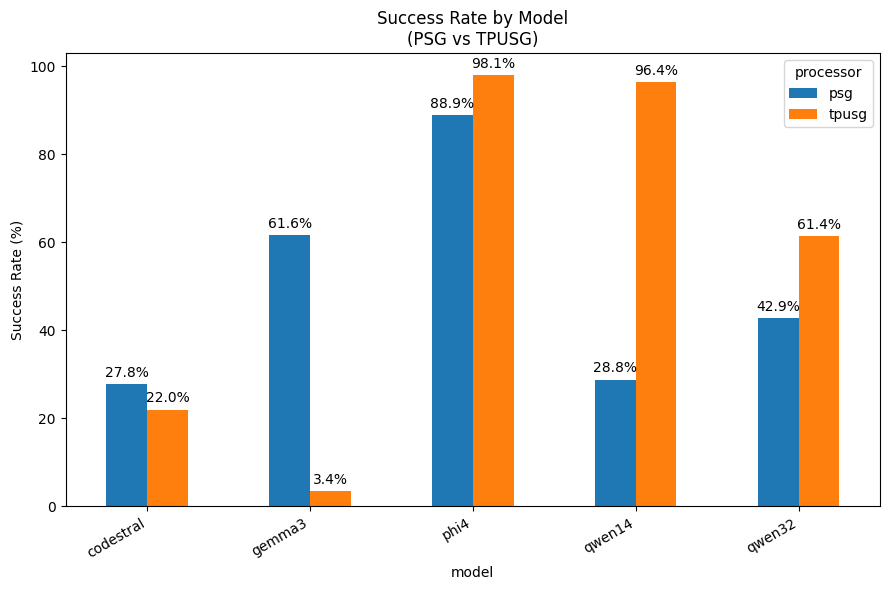

In [ ]:
metrics_by_model_processor = compute_metrics_by(cleaned_run_level, ["model", "processor"],['total_runs','success_rate','R_efficiency','R_exponential','R_linear','R_robust','avg_gen_count','tokens_ave','tokens_mean','tokens_median','tokens_min','tokens_max','latency_ave','latency_mean','latency_median','latency_min','latency_max',])
display(metrics_by_model_processor.round(3))

import pandas as pd
import matplotlib.pyplot as plt

# Pivot into wide format
pivot = metrics_by_model_processor.pivot(index="model", columns="processor", values="success_rate")

fig, ax = plt.subplots(figsize=(9,6))

pivot.plot(kind="bar", ax=ax)

ax.set_ylabel("Success Rate (%)")
ax.set_title("Success Rate by Model\n(PSG vs TPUSG)")

# Rotate x labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

# Add percentage labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", padding=3)

plt.tight_layout()
plt.show()


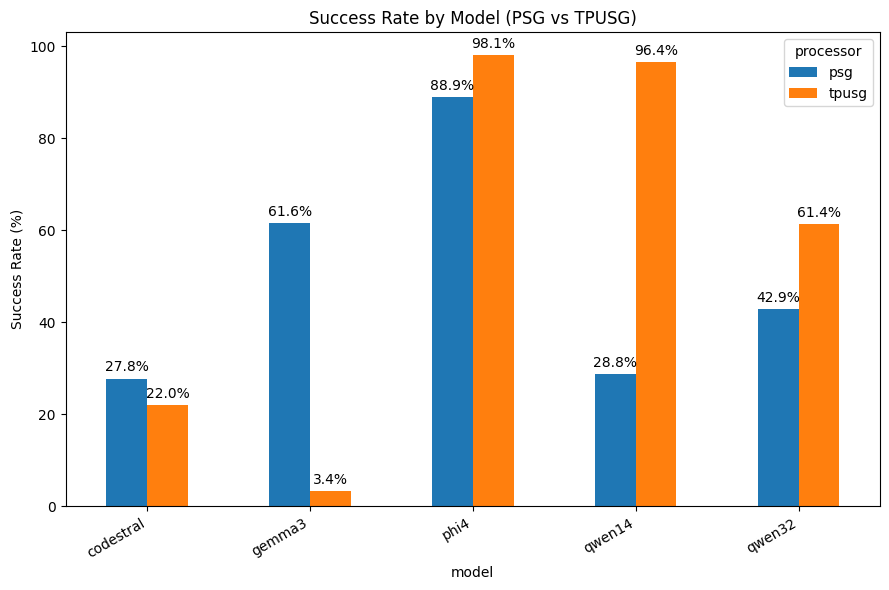

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume your raw run-level dataframe is:
# cleaned_run_level

# Compute success rate per (model, processor)
df_model_proc = (
    cleaned_run_level
    .groupby(["model", "processor"])
    .agg(
        total_runs=("status", "size"),
        success_count=("status", lambda s: (s == "success").sum())
    )
)

df_model_proc["success_rate"] = df_model_proc["success_count"] / df_model_proc["total_runs"] * 100

# Pivot to wide format for plotting
pivot = df_model_proc.reset_index().pivot(index="model", columns="processor", values="success_rate")

# Plot
fig, ax = plt.subplots(figsize=(9,6))
pivot.plot(kind="bar", ax=ax)

ax.set_ylabel("Success Rate (%)")
ax.set_title("Success Rate by Model (PSG vs TPUSG)")

# Rotate model names if needed
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")

# Annotate bars with % labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", padding=3)

plt.tight_layout()
plt.show()


In [ ]:
metrics_by_processor_params = compute_metrics_by(cleaned_run_level, ["processor","parameters"],['total_runs','success_rate','R_efficiency','R_exponential','R_linear','R_robust','avg_gen_count','tokens_ave','tokens_mean','tokens_median','tokens_min','tokens_max','latency_ave','latency_mean','latency_median','latency_min','latency_max',])
display(metrics_by_processor_params.round(3))

,processor,parameters,total_runs,success_rate,R_efficiency,R_exponential,R_linear,R_robust,avg_gen_count,tokens_ave,tokens_mean,tokens_median,tokens_min,tokens_max,latency_ave,latency_mean,latency_median,latency_min,latency_max
0,psg,False,372,57.796,31.501,33.209,41.075,46.129,3.522,9642.022,9642.022,11312.0,2220,15638,67.117,67.117,63.225,10.22,168.23
1,psg,True,455,42.637,25.227,24.360,27.121,30.154,4.066,10823.543,10823.543,12721.0,2242,17991,78.576,78.576,73.080,13.49,263.98
2,tpusg,False,394,75.888,55.918,57.942,64.264,69.391,2.530,7381.949,7381.949,5711.0,2499,16582,61.345,61.345,40.610,12.57,244.30
3,tpusg,True,433,54.273,45.050,44.930,47.159,48.360,3.185,9284.263,9284.263,11951.0,2609,16275,84.257,84.257,79.360,13.55,236.94


In [ ]:
for i in ['psg','tpusg']:

    total = cleaned_run_level[cleaned_run_level['processor']==i]['latency'].count()
    print(total)

    success = cleaned_run_level[cleaned_run_level['processor']==i][cleaned_run_level["status"]=='success']['latency'].count()
    print(success)
    success_rate = (success/total)*100
    print(f"Success rate for {i} is {success_rate} %")


827
409
Success rate for psg is 49.4558645707376 %
827
534
Success rate for tpusg is 64.57073760580411 %


/tmp/ipykernel_714776/2017014650.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  success = cleaned_run_level[cleaned_run_level['processor']==i][cleaned_run_level["status"]=='success']['latency'].count()
/tmp/ipykernel_714776/2017014650.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  success = cleaned_run_level[cleaned_run_level['processor']==i][cleaned_run_level["status"]=='success']['latency'].count()
